In [1]:
from neuron import h
import os
import numpy as np
import matplotlib.pyplot as plt
from plots import plot_cell, plot_cell_with_electrode, plot_bc_rgc
from BC_model_template import ONBipolarCell
from helperFuns import move_rgc_along_z
from Stimulation import Stimulus
import matplotlib.pyplot as plt

--No graphics will be displayed.


In [2]:
# Load compiled channel mechanisms and standard run system
h.nrn_load_dll("/Users/lillikiessling/Documents/Stanford/Code/BC_model/Ion_channels/arm64/libnrnmech.dylib")
h.load_file('stdrun.hoc') 
#h.load_file("nrn/cells/gc.nrn")            # defines soma, dend1[], dend2[], dend3[], dend4[], dend5[], dend6[]
h.load_file("RGC_model_Anna/RGC_20171004_S1W3C3_ON_S_200um_dend_low_14um_diameter_3um_axon_up_6um_axon_sections_20_axon_points_3000_axon_diam_1um.hoc")  # defines soma, dend[], axon[]
h.load_file("nrn/cells/BC_Euler9_ON.hoc")

1.0

### 1. RGC Cell

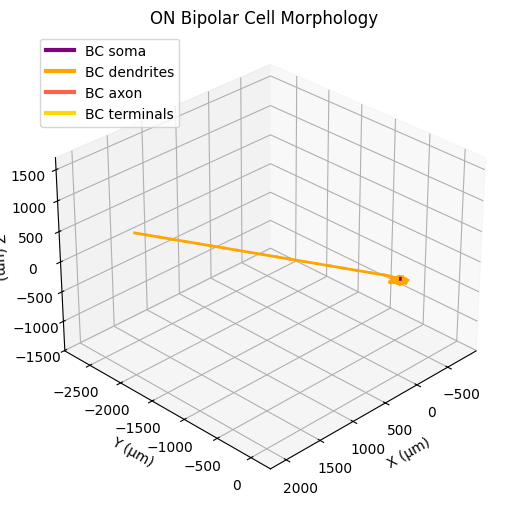

In [3]:
rgc_cell = h.RGC_20171004_S1W3C3_ON_S_200um_dend_low_14um_diameter_3um_axon_up_6um_axon_sections_20_axon_points_3000_axon_diam_1um()
move_rgc_along_z(rgc_cell, 100)
plot_cell(rgc_cell)


### 2. BC Cell

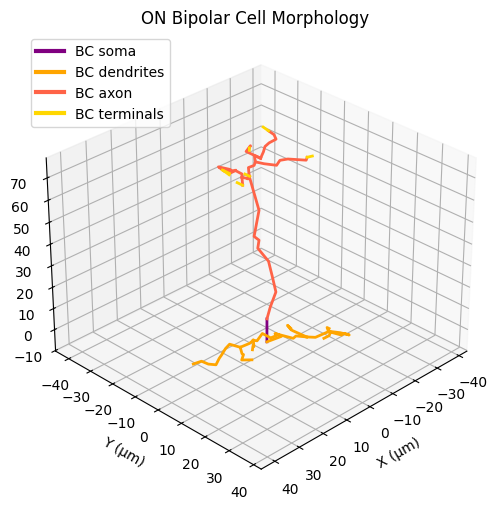

In [4]:
bc_cell = ONBipolarCell()
# Choose one Terminal for voltage clamp
term_list = list(bc_cell.terminal)
preSyn = term_list[0]

for sec in bc_cell.all:
    sec.cao = 1.8 #mM
    sec.cai = 0.0001 #mM

preSyn.gcabar_Bip_CaL = 0.4352 * 10

plot_cell(bc_cell)

### 3. Connect with ribbon tiger synapse

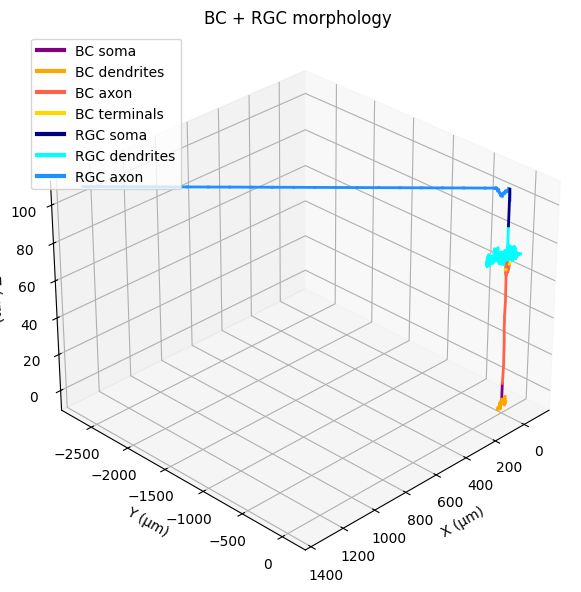

In [5]:
plot_bc_rgc(bc_cell, rgc_cell)

def make_syn_at(sec, idx):
    """Create a ribbon_tiger at sec(0.5) with Ca pointers hooked up."""
    syn = h.ribbon_tiger_simple(sec(0.5))
    h.setpointer(preSyn(0.5).ca_ion._ref_cai,  'preCA', syn)
    return syn

#MAPPING TABLE
mapped_dend1 = [26,27,28,29,30,31,32,33,34,35,36,37,38,39]   # 14
mapped_dend2 = [62,63,64]                                   # 3
mapped_dend3 = [21]                                         # 1
mapped_dend4 = [59]                                         # 1
mapped_dend5 = [60]                                         # 1
mapped_dend6 = [0,1,2]                                      # 3

# Full list of 23 synaptic *locations*
syn_locs = (
    mapped_dend1 +
    mapped_dend2 +
    mapped_dend3 +
    mapped_dend4 +
    mapped_dend5 +
    mapped_dend6
)

assert len(syn_locs) == 23

# Allocate arrays
synapse  = [None]*23
synapse2 = [None]*23
synapse3 = [None]*23

# Create synapses for all 23 locations × 3 ribbons
for idx, dend_idx in enumerate(syn_locs):
    sec = rgc_cell.dend[dend_idx]
    synapse[idx]  = make_syn_at(sec, idx)
    synapse2[idx] = make_syn_at(sec, idx)
    synapse3[idx] = make_syn_at(sec, idx)

def set_stim(GMAX=0.00256*8, GMAXN=0.00011*8):
    for arr in (synapse, synapse2, synapse3):
        for s in arr:
            if s is None:
                continue
            s.gmax       = GMAX
            s.gmaxN      = GMAXN
            s.mg         = 0.5
set_stim()

### 4. Point source Stimulation

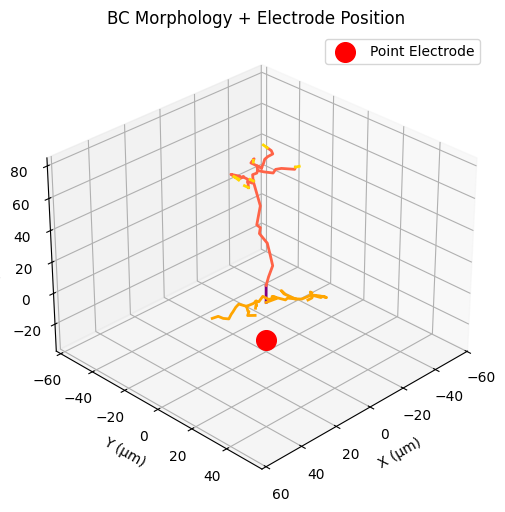

In [6]:
Stim_obj = Stimulus()
Stim, tsvec, isvec = Stim_obj.make_Stim(cell=bc_cell, duration=10, amplitude=-50.0, type ='extracellular', stimXShift=0, stimYShift=0, stimZShift=- 30, name='PointSource')
plot_cell_with_electrode(bc_cell, Stim)

In [7]:
t_vec = h.Vector().record(h._ref_t)
# --- Record BC dendrite Vm ---
#d = list(bc_cell.dendritic)[0]
d = next(iter(bc_cell.dendritic))
print("Recording from:", d.name())
v_bc_dend = h.Vector().record(d(0.5)._ref_v)

# --- Record RGC soma Vm ---
v_rgc_soma = h.Vector().record(rgc_cell.soma(0.5)._ref_v)

Recording from: BC_Euler9_ON[0].dend[0]


In [8]:
h.tstop = Stim['initDur']
h.dt = Stim['initDt']
#h.finitialize(Stim['vInit'])
h.finitialize(-80)
h.continuerun(h.tstop)
h.tstop = Stim['initDur'] + Stim['stop']
h.dt = Stim['dt']
h.continuerun(h.tstop)

0.0

In [9]:
t_np = t_vec.as_numpy()
v_bc_np = v_bc_dend.as_numpy()
print("BC Vm min/max:", v_bc_np.min(), v_bc_np.max())
v_rgc_np = v_rgc_soma.as_numpy()

BC Vm min/max: -80.0 124.56689561015118


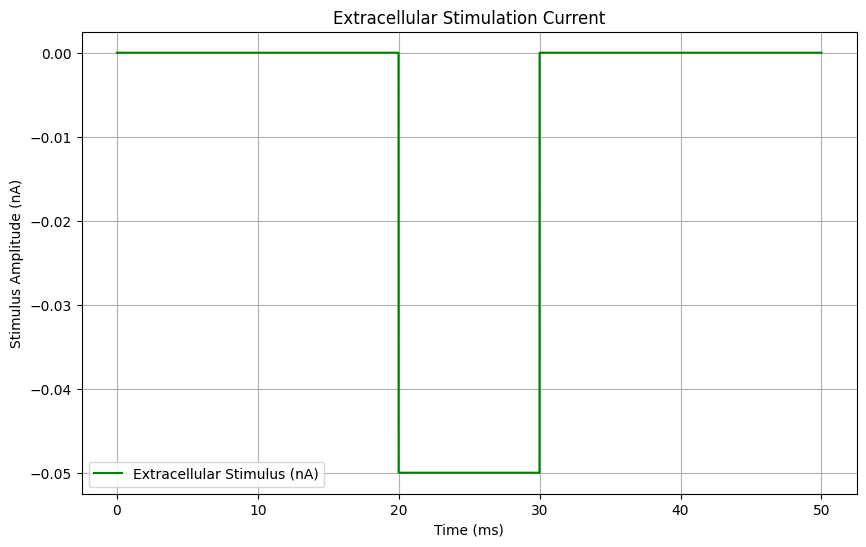

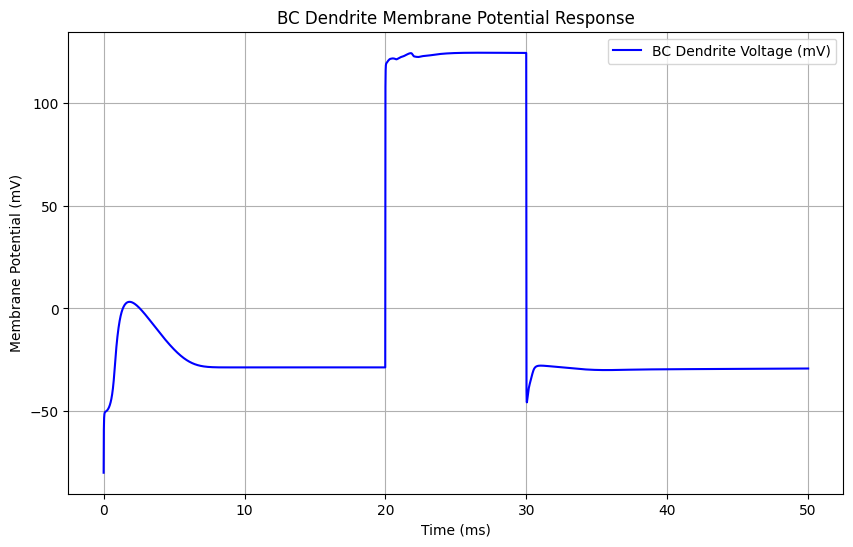

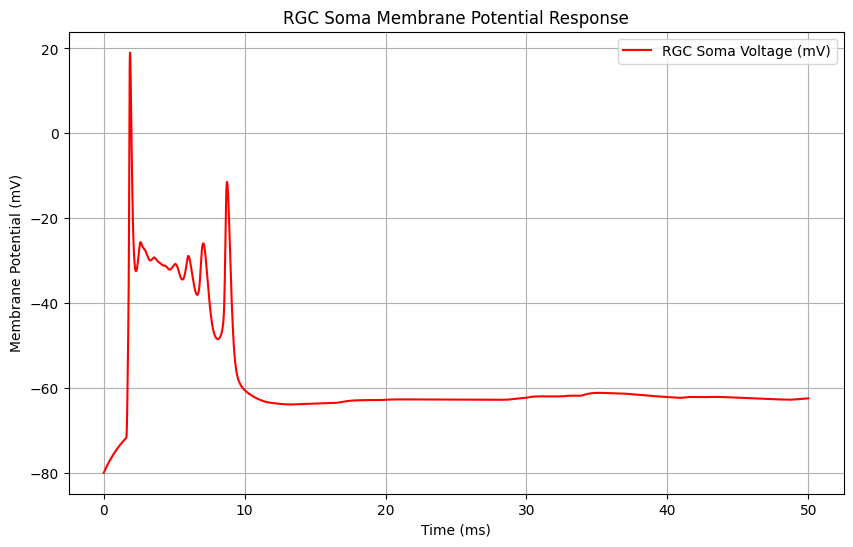

In [10]:
# --- Plot results ---
# A : Stimulus
plt.figure(figsize=(10,6))
plt.plot(tsvec, isvec, label='Extracellular Stimulus (nA)', color='green')
plt.xlabel('Time (ms)')
plt.ylabel('Stimulus Amplitude (nA)')
plt.title('Extracellular Stimulation Current')
plt.legend()
plt.grid()
plt.show()

# B : BC Dendrite 
plt.figure(figsize=(10,6))
plt.plot(t_np, v_bc_np, label='BC Dendrite Voltage (mV)', color='blue')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('BC Dendrite Membrane Potential Response')
plt.legend()
plt.grid()
plt.show()

# C : RGC Soma
plt.figure(figsize=(10,6))
plt.plot(t_np, v_rgc_np, label='RGC Soma Voltage (mV)', color='red')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('RGC Soma Membrane Potential Response')
plt.legend()
plt.grid()
plt.show()
